# Problem 1: Random Walk Monte Carlo

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

Write your own Random Walk MCMC algorithm from scratch. Don't worry if it is slow or inefficient - this exercise is about intuition building, not results. Use your sampler to fit a line to the data and generate samples from the posterior. For a first pass, run the sampler for a fixed number of steps, $N$. Then, modify the sampler to automatically stop running when a target number of effective samples $N_{\rm eff}$ has been reached.

# Problem 2: Fitting a Line

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

a) Fit the data using an ensemble sampler of your choice (recommendation: `emcee`)

b) Fit the data using a Hamiltonian Monte Carlo Sampler of your choice (recommendation: `PyMC` or `NumPyro`)

c) Fit the data using a nested sampler of your choice (recommendation: `dynesty`, `UltraNest`)

For all three cases, explicity write down the likelihood function; the `emcee` documentation has a clear explanation of how to do this. For Nested Sampling, you will also need to write a prior transform function; the `dynesty` documentation has a clear explanation of how to do this. Play around with using different priors (e.g. Gaussian, Uniform, Log-Uniform) to get a feel for the syntax of the different packages.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

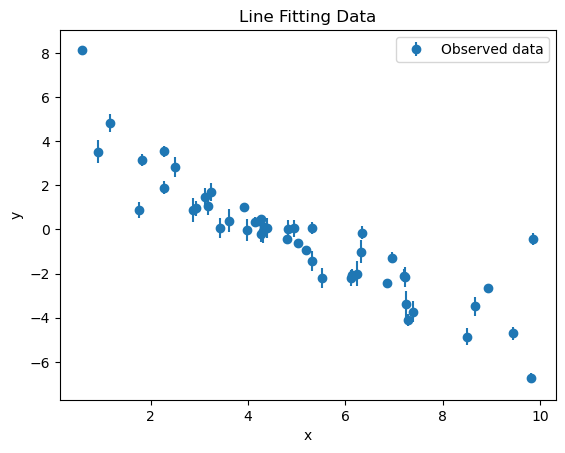

In [17]:
data = pd.read_csv('line_fitting.csv')
x_obs = data['x'].values
y_obs = data['y'].values
y_obs_unc = data['y_err'].values 

plt.errorbar(x_obs, y_obs, yerr=y_obs_unc, fmt='o', label='Observed data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Line Fitting Data')
plt.legend()
plt.show()

You must install the tqdm library to use progress indicators with emcee


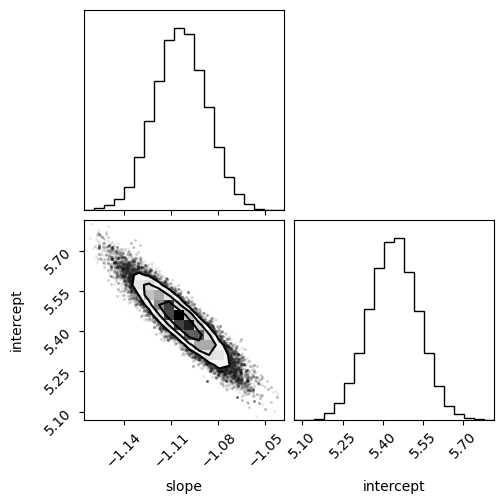

In [28]:
import emcee

def model(theta, x):
    m, b = theta
    return m * x + b

def log_likelihood(theta, x, y, yerr):
    m, b = theta
    model_y = m * x + b
    return -0.5 * np.sum(((y - model_y) / yerr) ** 2)

def log_prior(theta):
    m, b = theta
    if -10 < m < 10 and -10 < b < 10:
        return 0.0
    return -np.inf

# def log_posterior(theta, x, y, yerr):
#     lp = log_prior(theta)
#     if not np.isfinite(lp):
#         return -np.inf
#     return lp + log_likelihood(theta, x, y, yerr)

ndim = 2
nwalkers = 100
p0 = np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(x_obs, y_obs, y_obs_unc))

sampler.run_mcmc(p0, 1000, progress=True)

samples = sampler.get_chain(discard=500, flat=True)

import corner
fig = corner.corner(samples, labels=["slope", "intercept"])
plt.show()

In [15]:
print(sampler)

In [13]:
import pymc as pm
import arviz as az

with pm.Model() as model:
    m = pm.Normal("slope", mu=0, sigma=10)
    b = pm.Normal("intercept", mu=0, sigma=10)
    # sigma = pm.HalfNormal("sigma", sigma=10)
    
    mu = m * x_obs + b
    y_obs_ = pm.Normal("y_obs", mu=mu, sigma=y_obs_unc, observed=y_obs)
    
    trace = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.


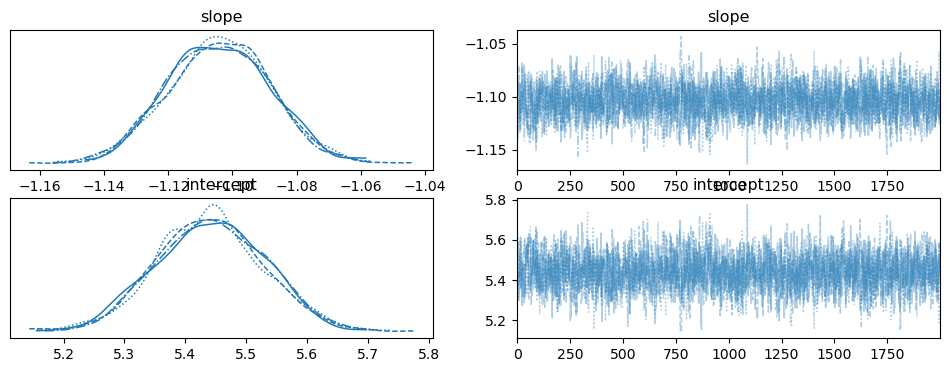

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,-1.104,0.016,-1.134,-1.076,0.000,0.000,1824.0,2154.0,1.0
intercept,5.441,0.089,5.279,5.608,0.002,0.001,1866.0,2302.0,1.0


In [14]:
az.plot_trace(trace)
plt.show()

az.summary(trace)

iter: 6 | bound: 0 | nc: 1 | ncall: 506 | eff(%):  1.186 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.118 | dlogz:    inf >  0.509                                                      

iter: 7340 | +500 | bound: 14 | nc: 1 | ncall: 28443 | eff(%): 28.057 | loglstar:   -inf < -615.556 <    inf | logz: -629.383 +/-  0.160 | dlogz:  0.001 >  0.509                                     

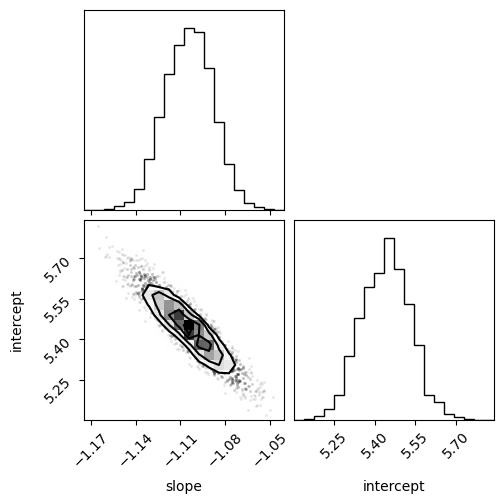

In [38]:
import dynesty
from dynesty import NestedSampler, utils as dyfunc

def log_likelihood(theta):
    m, b = theta
    model_y = m * x_obs + b
    return -0.5 * np.sum(((y_obs - model_y) / y_obs_unc) ** 2)

def prior_transform(u):
    m = -10 + 20 * u[0]   
    b = -100 + 200 * u[1] 
    return np.array([m, b])


sampler = NestedSampler(log_likelihood, prior_transform=prior_transform, ndim=2)
sampler.run_nested()
results = sampler.results

samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
samples_equal = dyfunc.resample_equal(samples, weights)

import corner
fig = corner.corner(samples_equal, labels=["slope", "intercept"])
plt.show()

# Problem 3: Astrophysics

Select an astrophysical dataset of your choosing. Fit the data using (a) an ensemble sampler, (b) HMC, and (c) Nested Sampling. Verify that the three methods produce equivalent results.